In [1]:
import os
import numpy as np
import pandas as pd

from fpdf import FPDF
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import from_mouseQC as mqc

In [3]:
pass_flag_fail_palette = {
    'pass'   : '#4CAF50', # Green
    'flag'   : '#FFC107', # Amber
    'fail'   : '#F44336', # Red
    'missing': '#D3D3D3', # Light gray
}

qc_gen_sub_status_palette = {
     "error"     :"#a6611a",  # brown
     "complete"  :"#940094",  # purple
     "incomplete":"#4a0094",  # blue
     "pass"      :"#8dd3c7",  # slightly desaturated cyan
     "flag"      :"#ffffb3",  # light yellow
     "fail"      :"#fb8072"   # light red
}


def plot_status_by_id_matrix(df: pd.DataFrame,
                             id_col: str,
                             color_mapping: dict,
                             save_path: str = None,
                             xlabel: str = None,
                             ylabel: str = None,
                             title: str = None,
                             figsize: tuple = (10, 8),
                             show_labels: bool = True):
    """a generic function that will take a dataframe of a specific structure
    and create a colored grid plot based on the values in the dataframe
    y axis: ids 
    x axis: all other columns in the dataframe

    Parameters
    ----------
    df : pd.DataFrame
        a dataframe with a specific structure:
        - first column is an id column (e.g. ophys_session_id, ophys_experiment_id)
        - all remaining columns contain string values that are keys in the color_mapping dictionary
        the strings represent the status of the given column

        example: df with columns: ophys_session_id, data_stream_1, data_stream_2, data_stream_3
        where all the string data_stream columns can be "pass", "flag", "fail"

    color_mapping : dict
        the color mapping dictionary that maps the string values in the dataframe to colors
    figsize : tuple, optional
        size of the figure, by default (10,8)
    save_path : str, optional
        location to save the plot, by default None
    show_labels : bool, optional
        whether to show labels on the patches, by default True
    """
    # Define default color for NaN values
    default_color = color_mapping.get('missing', '#D3D3D3')  # Light gray as default

    # Create a color matrix based on the DataFrame values
    color_matrix = df.iloc[:, 1:].applymap(lambda x: color_mapping.get(x, default_color))

    # Plotting the colored grid
    fig, ax = plt.subplots(figsize=figsize)

    # Create a grid of colored boxes
    for (row_idx, col_idx), val in np.ndenumerate(df.iloc[:, 1:].values):
        color = color_mapping.get(val, default_color)
        ax.add_patch(plt.Rectangle((col_idx, row_idx), 1, 1, color=color))
        if show_labels:
            ax.text(col_idx + 0.5, row_idx + 0.5, str(val), ha='center', va='center', color='black')

    # Set ticks and labels
    ax.set_xticks(np.arange(len(df.columns[1:])) + 0.5)
    ax.set_yticks(np.arange(len(df)) + 0.5)
    ax.set_xticklabels(df.columns[1:], rotation=90)
    ax.set_yticklabels(df[id_col])

    # Add gridlines
    ax.hlines(np.arange(len(df) + 1), *ax.get_xlim(), color='gray')
    ax.vlines(np.arange(len(df.columns[1:]) + 1), *ax.get_ylim(), color='gray')

    # Remove the default spines
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add axis labels if provided
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

    # Add title if provided
    if title:
        ax.set_title(title)

    # Create a custom legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[key]) for key in color_mapping.keys()]
    labels = list(color_mapping.keys())
    ax.legend(handles, labels, title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Save the plot if a save path is provided, otherwise show the plot
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()
    

def plot_impacted_data_outcomes_matrix(data_stream_outcomes_df: pd.DataFrame, 
                                       id_col: str = "data_id",
                                       color_mapping:dict=pass_flag_fail_palette,
                                       save_path: str = None,
                                       xlabel:str="Impacted Data",
                                       ylabel:str="Data ID",
                                       title:str="Impacted Data QC Outcomes",
                                       show_labels: bool = True):
    """Plot a matrix of the QC outcomes for each impacted data stream or context.
    Input dataframe should be limited to sessions/exeriments that have COMPLETED
    QC Generation and Review.

    Parameters
    ----------
    data_stream_outcomes_df : pd.DataFrame
        table with a column for data_id and columns for each impacted
        data (data streams, data context) with values of "pass", "flag", "fail"
    id_col : str, optional
        name of column that has the data id (i.e. "ophys_session_id", etc),
        by default "data_id"
    color_mapping : dict, optional
        keys are data outcomes like "pass", "flag" etc. 
        values are colors for those outcomes, 
        by default pass_flag_fail_palette
    save_path : str, optional
        location to save the plot, by default None
    xlabel : str, optional
        label for x axis of plot, by default "Impacted Data"
    ylabel : str, optional
        label for y axis of plot, by default "Data ID"
    title : str, optional
        plot title, by default "Impacted Data QC Outcomes"
    show_labels : bool, optional
        whether to show labels on the patches, by default True
    """
    plot_status_by_id_matrix(data_stream_outcomes_df,
                             id_col=id_col,
                             color_mapping=color_mapping,
                             save_path=save_path,
                             xlabel=xlabel,
                             ylabel=ylabel,
                             title=title,
                             show_labels=show_labels)


def plot_qc_submit_status_matrix(submit_status_df:pd.DataFrame, 
                                id_col: str = "data_id",
                                color_mapping:dict=qc_gen_sub_status_palette,
                                save_path: str = None,
                                xlabel:str="QC Status",
                                ylabel:str="Data ID",
                                title:str="QC Generation & Submission Status",
                                show_labels: bool = True):
    """ Plot a matrix of the QC generation and submission status for each
     dataset (session, experiment etc.)

    Parameters
    ----------
    submit_status_df : pd.DataFrame
        table with the following columns:
            - generation_status
            - review_status
            - qc_outcome
    id_col : str, optional
        name of column for data unit, examples: "ophys_session_id", by default "data_id"
    color_mapping : dict, optional
        keys are data outcomes like "pass", "flag" etc. 
        values are colors for those outcomes, 
        by default pass_flag_fail_palette
    save_path : str, optional
        location to save the plot, by default None
    xlabel : str, optional
        label for x axis of plot, by default "QC Status"
    ylabel : str, optional
        label for y axis of plot, by default "Data ID"
    title : str, optional
        plot title, by default "QC Generation & Submission Status"
    show_labels : bool, optional
        whether to show labels on the patches, by default True
    """
    plot_status_by_id_matrix(submit_status_df,
                            id_col=id_col,
                            color_mapping=color_mapping,
                            save_path=save_path,
                            xlabel=xlabel,
                            ylabel=ylabel,
                            title=title,
                            show_labels=show_labels)

In [4]:
NUM_DAYS = 30 # Number of days to look back for data

CSV_SAVE_PATH  = "\\allen\programs\mindscope\workgroups\learning\mouse-qc\csvs"
PLOT_SAVE_PATH = "\\allen\programs\mindscope\workgroups\learning\mouse-qc\plots"
PDF_SAVE_PATH  = "\\allen\programs\mindscope\workgroups\learning\mouse-qc\reports"

In [5]:
# Sessions & Experiments from last 21 days
sessions_df = mqc.gen_session_qc_info_for_date_range(range_in_days = NUM_DAYS)
session_ids_list = sessions_df["ophys_session_id"].tolist()
__, experiment_ids_list = mqc.get_experiment_ids_for_session_ids(session_ids_list)
experiments_df = mqc.gen_experiment_qc_info_for_ids(experiment_ids_list)

# Mouse summary for all mice within that date range
mouse_df = mqc.summarize_mouse_df(sessions_df)

In [ ]:
mouse_df

In [ ]:
session_qc_status = sessions_df[["ophys_session_id", "generation_status", "review_status", "qc_outcome"]]
exp_qc_status = experiments_df[["ophys_experiment_id", "generation_status", "review_status", "qc_outcome"]]


In [ ]:
mouse_exp_qc_status = experiments_df[["mouse_id",
                                      "ophys_experiment_id",
                                      "generation_status",
                                      "review_status",
                                      "qc_outcome"]]
for mouse_id, group_df in df.groupby('mouse_id'):
    plot_data(group_df, mouse_id)
    plot_qc_submit_status_matrix(group_df,
                             "ophys_experiment_id",
                             ylabel = "Experiment ID",
                            show_labels = False)

In [ ]:
mouse_exp_qc_status = experiments_df[["mouse_id",
                                      "ophys_experiment_id",
                                      "generation_status",
                                      "review_status",
                                      "qc_outcome"]]
mouse_qc_gb = mouse_exp_qc_status.groupby('mouse_id')


In [6]:
tags_df, other_tags, overrides_df = mqc.gen_tags_df_for_ids(session_ids_list,
                                                            experiment_ids_list)


In [11]:
tags_df

,data_id,qc_tag,qc_outcome,impacted_data,report_type
0,1371955818,nb_dropped_photodiode_events,flag,visual_stimulus,session
1,1371955818,vasculature_image_quality,flag,NaN,session
2,1372002843,eye_covered,flag,task_performance,session
3,1372002843,eye_covered,flag,eye_tracking,session
4,1372002843,eye_covered,flag,physiology_recording,session
...,...,...,...,...,...
422,1377847995,zdrift_severe,fail,physiology_recording,experiment
423,1377847998,z_drift_corr_um_diff,fail,physiology_recording,experiment
424,1377847998,zdrift_severe,fail,physiology_recording,experiment
425,1377848000,z_drift_corr_um_diff,fail,physiology_recording,experiment


In [9]:
def create_plot(dataframe, ax, title):
    """
    Create a bar plot for the given DataFrame.

    Parameters:
    dataframe (pd.DataFrame): DataFrame containing the data to plot.
    ax (matplotlib.axes.Axes): Axes object to draw the plot on.
    title (str): Title for the plot.
    """
    # Get frequency of each qc_tag
    freq_df = dataframe['qc_tag'].value_counts().reset_index()
    freq_df.columns = ['qc_tag', 'frequency']

    # Merge frequency with the original DataFrame to get qc_outcome
    merged_df = pd.merge(freq_df, dataframe[['qc_tag', 'qc_outcome']], on='qc_tag', how='left').drop_duplicates()

    # Order by frequency
    merged_df = merged_df.sort_values('frequency', ascending=False)

    # Create a bar plot
    sns.barplot(x='frequency', y='qc_tag', hue='qc_outcome', data=merged_df,
                palette={'fail': 'red', 'flag': 'yellow'}, dodge=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('QC Tag')

def plot_qc_tag_frequency(df, save_path=None, save_name=None):
    """
    Plot the frequency of each qc_tag, ordered by frequency, and colored by qc_outcome.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    save_path (str, optional): Directory path to save the plot. Defaults to None.
    save_name (str, optional): Name of the file to save the plot as. Defaults to None.
    """
    # Split the DataFrame by report_type
    session_df = df[df['report_type'] == 'session']
    experiment_df = df[df['report_type'] == 'experiment']

    # Plot settings
    fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=False)

    # Create plots for session and experiment data
    create_plot(session_df, axs[0], 'Session QC Tag Frequency')
    create_plot(experiment_df, axs[1], 'Experiment QC Tag Frequency')

    plt.tight_layout()

    # Save the plot if a save path and name are provided
    if save_path and save_name:
        save_file = os.path.join(save_path, save_name)
        plt.savefig(save_file)
        print(f'Saved plot to {save_file}')

    plt.show()

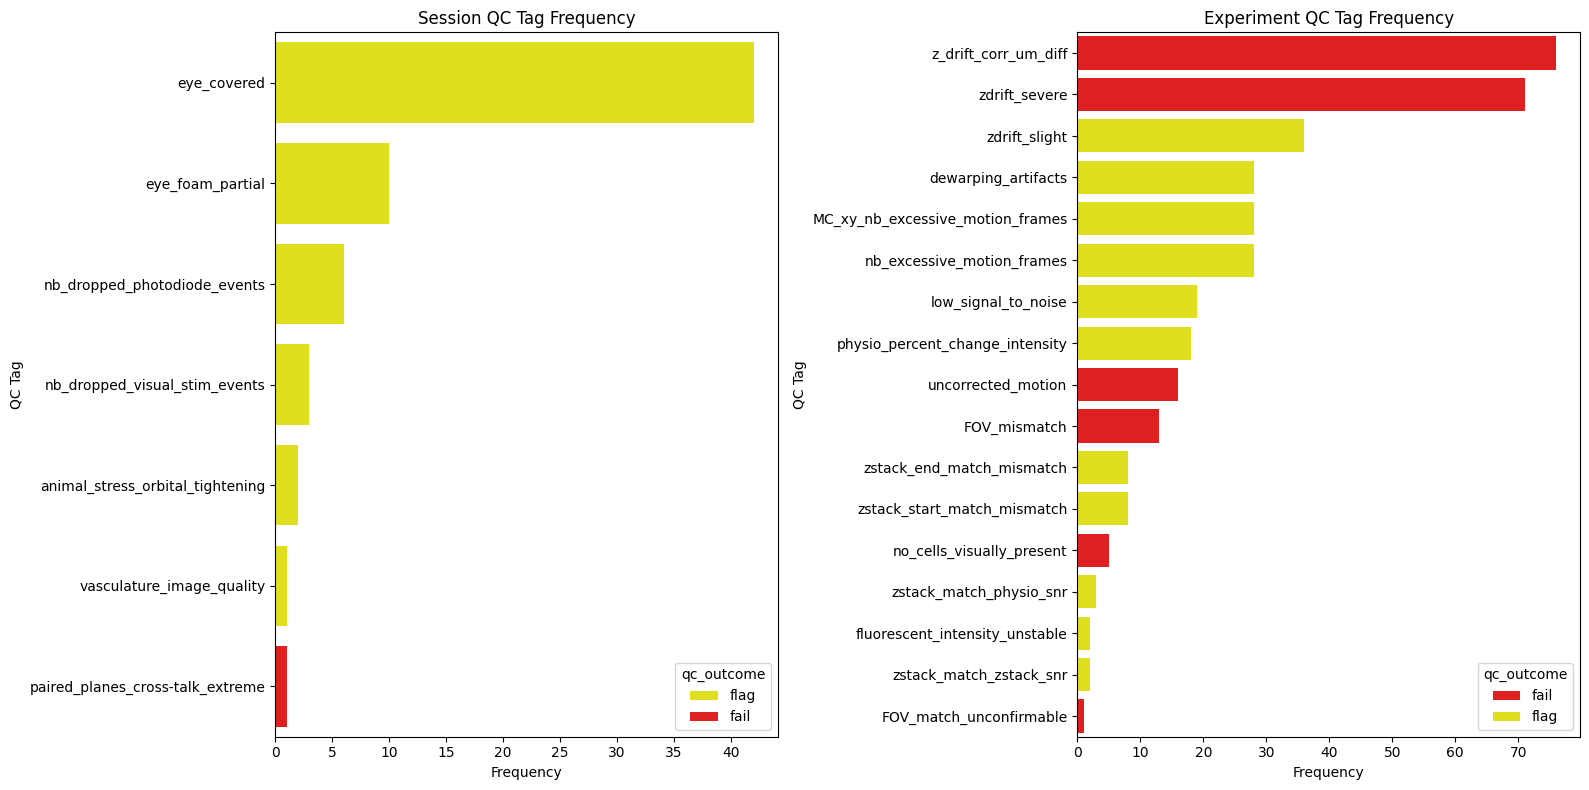

In [10]:
plot_qc_tag_frequency(tags_df)

In [8]:
tags_df

,data_id,qc_tag,qc_outcome,impacted_data,report type
0,1371955818,nb_dropped_photodiode_events,flag,visual_stimulus,session
1,1371955818,vasculature_image_quality,flag,NaN,session
2,1372002843,eye_covered,flag,task_performance,session
3,1372002843,eye_covered,flag,eye_tracking,session
4,1372002843,eye_covered,flag,physiology_recording,session
...,...,...,...,...,...
422,1377847995,zdrift_severe,fail,physiology_recording,experiment
423,1377847998,z_drift_corr_um_diff,fail,physiology_recording,experiment
424,1377847998,zdrift_severe,fail,physiology_recording,experiment
425,1377848000,z_drift_corr_um_diff,fail,physiology_recording,experiment


In [ ]:
for mouse_id, group_df in df.groupby('mouse_id'):
    plot_data(group_df, mouse_id)

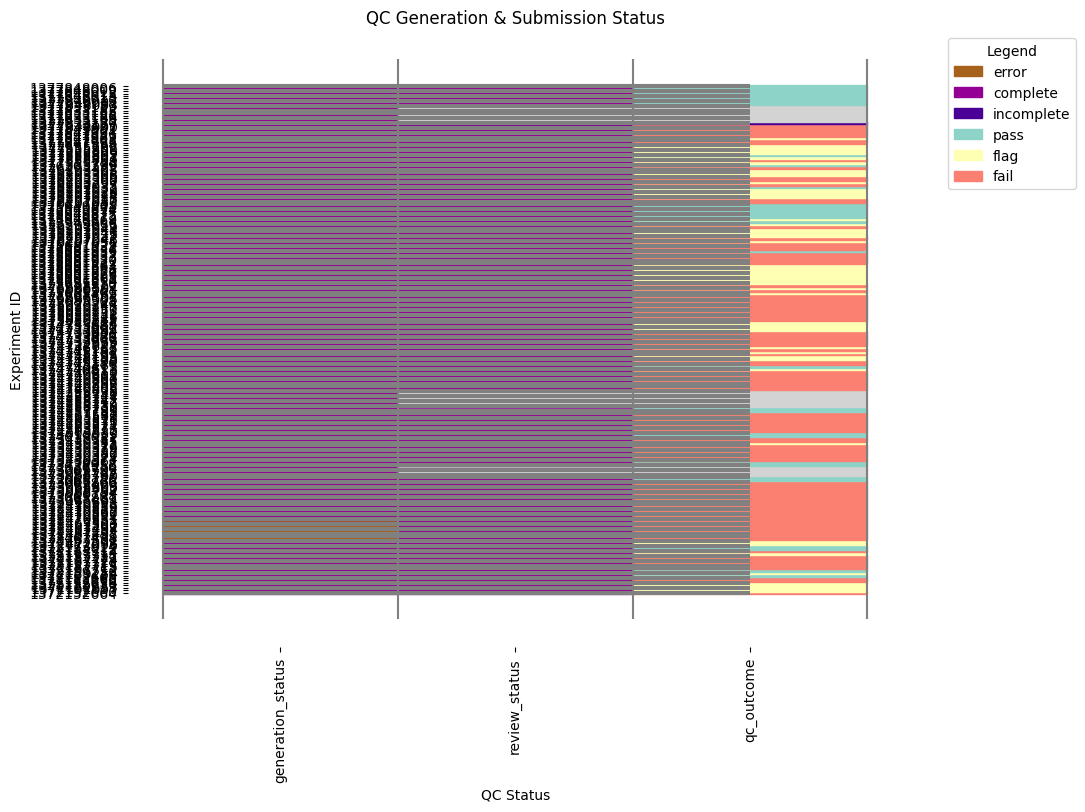

In [14]:
plot_qc_submit_status_matrix(exp_qc_status,
                             "ophys_experiment_id",
                             ylabel = "Experiment ID",
                            show_labels = False)

In [26]:
completed_sessions_list = session_qc_status.loc[session_qc_status["review_status"]=="complete", "ophys_session_id"].tolist()

In [28]:
impacted_data_df = mqc.gen_session_impacted_data_outcome_df(completed_sessions_list)
impacted_data_df

,ophys_session_id,physio_sync,eye_tracking,face_tracking,body_tracking,running_wheel,water_delivery,lick_detection,visual_stimulus,metadata,columnar_zstack,mouse_stress,mouse_health,brain_health,stimulus_sequence_progression,task_performance,mouse_behavior
0,1373167919,pass,flag,pass,pass,pass,pass,pass,flag,pass,pass,flag,pass,pass,pass,pass,pass
1,1373217711,pass,flag,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,flag,pass
2,1373231491,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass
3,1373890769,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass
4,1374088712,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass
5,1374103167,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass
6,1374531770,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass
7,1374533626,pass,pass,pass,pass,pass,pass,pass,flag,pass,pass,pass,pass,pass,pass,pass,pass
8,1374549391,pass,flag,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,flag,pass
9,1374600699,pass,flag,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,pass,flag,pass


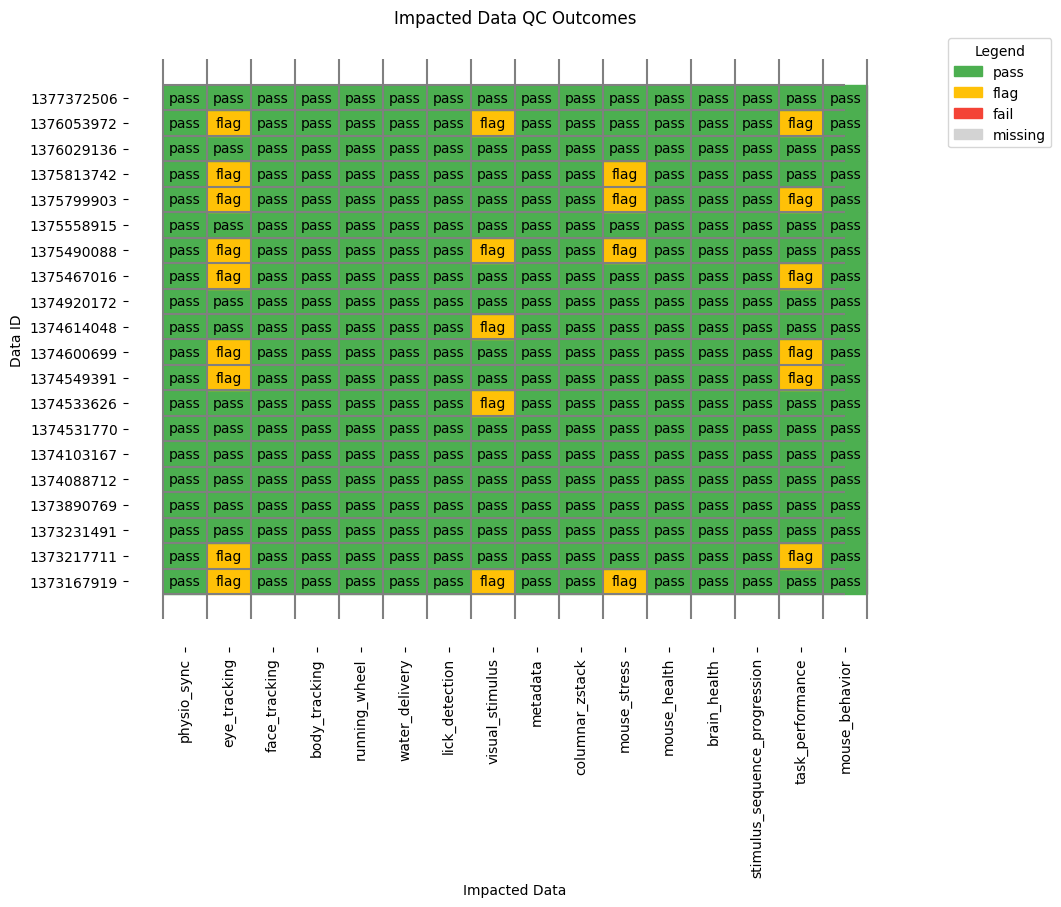

In [29]:
plot_impacted_data_outcomes_matrix(impacted_data_df, "ophys_session_id")